# Inference

In [47]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import albumentations as A

from mmseg.registry import MODELS, RUNNERS
from mmengine.config import Config

In [2]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [3]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [4]:
cfg = Config.fromfile("./configs/custom_configs/segformer/config_for_this_example.py")
# cfg.test_evaluator.outfile_prefix = "./mmsegmentation/work_dirs/Segformer"
cfg.launcher = "none"
# resume training
cfg.resume = False
cfg.work_dir = './work_dirs/Segformer'
cfg.checkpoint = "iter_30000"
cfg.load_from = os.path.join(cfg.work_dir, f"{cfg.checkpoint}.pth")
runner = RUNNERS.build(cfg)
# runner = Runner.from_cfg(cfg)
model = MODELS.build(cfg.model)

02/19 23:41:02 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1711340929
    GPU 0: Tesla V100-SXM2-32GB
    CUDA_HOME: None
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-g

02/19 23:41:04 - mmengine - INFO - Config:
checkpoint = 'iter_30000'
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        0.0,
        0.0,
        0.0,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        255.0,
        255.0,
        255.0,
    ],
    type='SegDataPreProcessor')
data_root = '../../data/'
dataset_type = 'XRayDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=2000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
launcher = 'none'
load_from = './work_dirs/Segformer/iter_30000.pt

/data/ephemeral/home/level2-cv-semanticsegmentation-cv-04/CSH/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/data/ephemeral/home/level2-cv-semanticsegmentation-cv-04/CSH/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


02/19 23:41:08 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/19 23:41:08 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/data/ephemeral/home/level2-cv-semanticsegmentation-cv-04/CSH/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [5]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../../data/test/DCM"

In [ ]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [7]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [26]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [32]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in enumerate(data_loader):
            images = images.cuda()
            outputs = model(images)
            
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [33]:
tf = A.Resize(512, 512)

In [34]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [35]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [36]:
rles, filename_and_class = test(model, test_loader)

# Result Visualization

In [37]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [41]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[1].split("_")[1]))

In [42]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

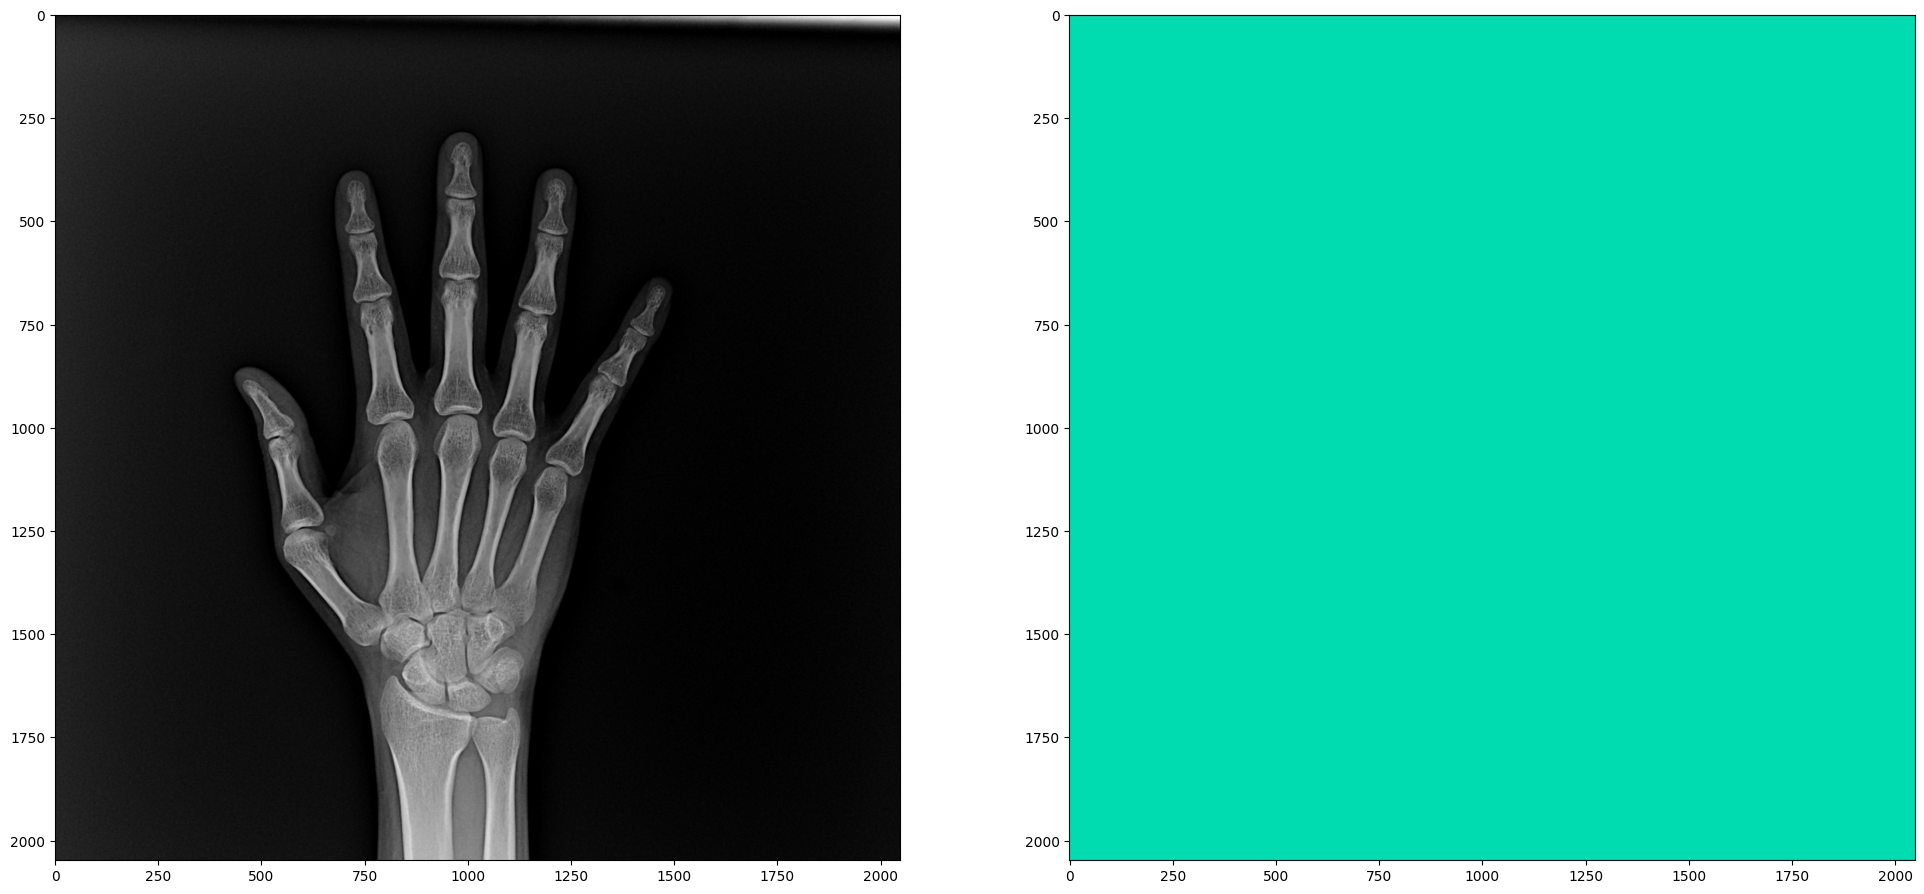

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [44]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [45]:
image_name = [os.path.basename(f) for f in filename]

In [48]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [49]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1 147559 147562 2043 149614 2036 151666 2028 1...
1,image1661319116107.png,finger-2,1 437 2049 437 4097 437 6145 437 8193 437 1024...
2,image1661319116107.png,finger-3,81 1968 2129 1968 4177 1968 6225 1968 8273 196...
3,image1661319116107.png,finger-4,1 79 2049 79 4097 79 6145 79 8193 79 10241 79 ...
4,image1661319116107.png,finger-5,151736 7 153768 43 155810 76 157853 88 159898 ...
5,image1661319116107.png,finger-6,1 2460599 2460601 2046 2462650 2044 2464698 20...
6,image1661319116107.png,finger-7,
7,image1661319116107.png,finger-8,1 4194304
8,image1661319116107.png,finger-9,
9,image1661319116107.png,finger-10,225304 2 227352 2 229399 3 231447 3 233494 5 2...


In [51]:
df.to_csv("./work_dirs/Segformer/output.csv", index=False)